# Ephemeris object imaging: continuum (mosaic gridder) - explicitly specified the internal epehemeris table example

####  Note: This demo works with CAS-13593 fix

## Description
The following demo describes continuum imaging of ALMA observation of Venus. For imaigng of the sources that move significantly during the observations, proper ephemeris data need to be used. For the current ALMA data, the epehemeris tables used to track the source during the observation generally included in the ASDM. The task, importasdm attaches the ephemeris table(s) in FIELD sub-table in the generated MS. Here we starts from such MS data and explicitly specify the attached ephemeris table. THis demo is otherwise identical to ALMAephemimagingVenusMfsMosaicTrackfield.ipynb.

## Data 
The data is available at /home/casa/data/casatestdata.

## Installation
### Option 1

### Option 2

### Import libraries

In [1]:
from casatasks import getephemtable, tclean, exportfits, listobs, clearstat, imstat
from casatools import measures, quanta, table, image, msmetadata
import os
from astropy.io import fits
from matplotlib import pyplot
import pylab as pl
import aplpy
import shutil
me = measures()
qa = quanta()
tb = table()
ia = image()
msmd = msmetadata()

#### Import utility functions defined in a separate notebook

In [2]:
# import helper functions defined in 'Trackfield' mfs mosaic notebook
# requires ipynb 
from ipynb.fs.defs.EphemerisObjectImagingDemoFunctions import *

In [3]:
datapath='/home/casa/data/casatestdata/measurementset/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/measurementset/alma/'
#datapath='/Users/ttsutsum/SWDevel/ephemdemo/notebooks/'

In [4]:
msfile='venus_ephem_test.ms'
if os.path.exists(msfile):
    shutil.rmtree(msfile)
os.system(f'cp -r {datapath}{msfile} {msfile}')

0

In [5]:
imgname='Venus-mosaic-mfs-explicitIntab'

In [6]:
delete_tcleanimages(imgname)

In [7]:
ephemtab = get_attachedEphemtablepath(msfile, 'Venus')
print(ephemtab)

venus_ephem_test.ms/FIELD/EPHEM0_Venus_58491.4.tab/


In [8]:
ret=tclean(vis=msfile, field='Venus', imagename=imgname, imsize=[480,432], cell=['0.14arcsec'], 
           phasecenter=ephemtab, specmode='mfs', gridder='mosaic', usepointing=True, niter=100)
ret['iterdone']

100

### Examination of the resultant image

Get the direction of Venus at the first timestamp of the select data from the ephemeris table

In [9]:
from casatasks import imhead
iminfo=imhead(imgname+'.image', mode='list')
iminfo['date-obs']

'2019/01/08/11:21:50.208000'

In [10]:
# Get the first time stamp 
msmd.open(msfile)
t0 = msmd.timesforfield(0)[0]
reftm=qa.quantity(t0,'s')
reftmcal = qa.time(reftm,form='ymd')
print(f'reftm:{reftmcal}')
msmd.done()
# Note that this time is different from what image header gives
# 
# find the direction of Venus (use the date-obs from the image header)

ineph_dir = ephem_dir(ephemtab, iminfo['date-obs'], 'ALMA')
print(ineph_dir)
ineph_rad = qa.convert(ineph_dir['m0'],'deg')
ineph_decd = qa.convert(ineph_dir['m1'],'deg')
inephmarker = {'ineph':{'ra':ineph_rad['value'], 'dec':ineph_decd['value']}}

reftm:['2019/01/08/11:23:28']
{'m0': {'unit': 'rad', 'value': -2.1053946095161686}, 'm1': {'unit': 'rad', 'value': -0.2960760011918846}, 'refer': 'ICRS', 'type': 'direction'}


INFO: Setting slices=[0, 0] [aplpy.core]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -3.736e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.666e+00 [aplpy.core]
ky=ineph
ineph at: 15:57:28.746, -016.57.50.059
image center: ('15:57:28.746', '-016.57.50.059')


<Figure size 1500x1500 with 0 Axes>

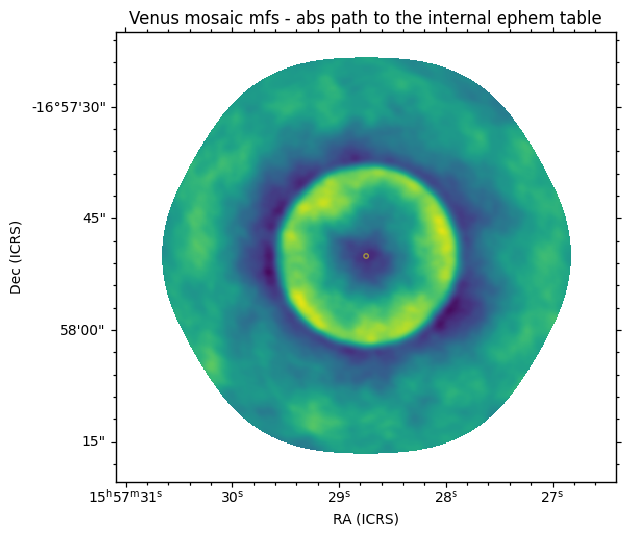

In [11]:
displayImage(imgname+'.image', markers=inephmarker, 
             title='Venus mosaic mfs - abs path to the internal ephem table')

As expected, the center of the image agrees with the position from the internal ephemeris table at the time recorded in the image header and the the source appears at the center of the image.
The result is identical to the tclean run with 'TRACKFIELD'.

In [12]:
print("internal ephem dir = ",qa.time(ineph_dir['m0'],prec=9),qa.angle(ineph_dir['m1'],prec=9))
printImageCenter(imgname+'.image')

internal ephem dir =  ['15:57:28.746'] ['-016.57.50.059']


('15:57:28.746', '-016.57.50.059')

In [13]:
stats = imstat(imgname+'.image')
print(f"{stats['max']}@{stats['maxpos']}")

[3.33059001]@[177 172   0   0]
